# Check the position of visits 

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-04-13
- last update : 2024-04-13 
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip


In [26]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = collection2
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
tract_sel = 2494
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [7]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [8]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [9]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


In [10]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [11]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [12]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [13]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[2494, 2495, 2661, 2662, 3200, 3345, 3346, 3384, 3385, 3533, 3534, 6914, 6915, 7148, 7149, 7445, 7446, 7683, 7684, 9570, 9637, 9638, 9812, 9813, 9880, 9881]


In [14]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [15]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [16]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
730865860864    20240403
730865860865    20240403
730865860866    20240403
730865860867    20240403
730865860868    20240403
                  ...   
730866060292    20240403
730866060293    20240403
730866060294    20240403
730866060295    20240403
730866060296    20240403
Name: nightObs, Length: 6301, dtype: int64

In [17]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [18]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_table_saved.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv found !!! ==> Read it !!!


In [19]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [20]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.471790,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.011240,-15.026212,0,0.711160,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,0,0,20240403,6914,246
730865860865,7024040300001,r_03,r,124.745824,-14.826505,18.059967,31.238535,1.508598,1674.763306,32.659889,0.004810,0.002649,521,-0.000758,0.000405,0.010847,0.010906,-0.000540,0.010071,0.006677,0.011858,327.926941,11.528691,1.124846,0.350736,0.974059,-14.826505,1,0.710764,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,1,0,20240403,7149,12
730865860866,7024040300001,r_03,r,124.873418,-14.626731,18.294695,31.259706,1.525470,1709.555664,33.396534,0.004649,0.002711,499,-0.000471,-0.000007,0.010723,0.010910,0.000434,0.009015,0.005919,0.015276,507.804199,11.484890,1.100101,0.343598,1.012796,-14.626731,2,0.718461,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,2,0,20240403,7149,61
730865860867,7024040300001,r_03,r,124.824851,-15.149693,17.819584,31.267454,1.514115,1717.083984,34.223988,0.004732,0.002868,504,-0.000470,-0.000685,0.009737,0.010434,-0.000375,0.010328,0.006824,0.019305,371.574188,11.773538,1.116663,0.342092,1.027357,-15.149693,3,0.713278,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,3,0,20240403,6914,227
730865860868,7024040300001,r_03,r,124.952564,-14.949870,18.054384,31.265049,1.510671,1714.527710,33.346077,0.004954,0.002795,472,0.000277,0.000023,0.009188,0.009661,0.000165,0.010904,0.007214,0.009335,364.833038,11.792562,1.121760,0.342602,1.022816,-14.949870,4,0.711782,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,4,0,20240403,6914,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r_03,r,299.857944,-40.858541,19.874241,31.276102,1.663994,1544.489258,31.839106,0.006128,0.003535,742,0.000638,-0.000605,0.012558,0.010842,-0.000502,0.011414,0.006865,0.012346,238.200607,11.011467,0.924563,0.380320,1.043851,-40.858541,4,0.784160,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199510,60404.435870,33.0575,4071,3999,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,299.860717,-41.017175,199428,779,20240403,3384,159
730866060293,7024040300780,r_03,r,300.072069,-40.688646,19.948414,31.241217,1.658965,1498.435913,32.142555,0.006090,0.003350,783,-0.000532,0.000092,0.010

In [21]:
cmap = ListedColormap(sns.color_palette("hls", NDET))
all_det_colors = [cmap.colors[idx] for idx in range(NDET)]

In [22]:
ser_tract_det_size = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["tractID","detector"]).size()

In [23]:
df_ccdvisit_pertractdet = ser_tract_det_size.unstack(level=1)

In [24]:
df_ccdvisit_pertractdet

detector,0,1,2,3,4,5,6,7,8
tractID,,,,,,,,,
0,2.0,2.0,2.0,NaN,NaN,2.0,7.0,1.0,1.0
2494,80.0,41.0,5.0,96.0,32.0,NaN,82.0,34.0,2.0
2495,18.0,60.0,86.0,5.0,69.0,100.0,15.0,67.0,98.0
2662,1.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3345,12.0,NaN,NaN,16.0,NaN,NaN,50.0,8.0,NaN
3346,NaN,1.0,NaN,10.0,10.0,17.0,34.0,69.0,74.0
3384,40.0,40.0,40.0,40.0,40.0,40.0,39.0,40.0,40.0
3533,105.0,112.0,115.0,90.0,107.0,99.0,30.0,38.0,40.0
6914,104.0,95.0,69.0,97.0,95.0,45.0,74.0,61.0,25.0


<Axes: title={'center': 'Number of ccdvisits per patch per detector'}, xlabel='tractID'>

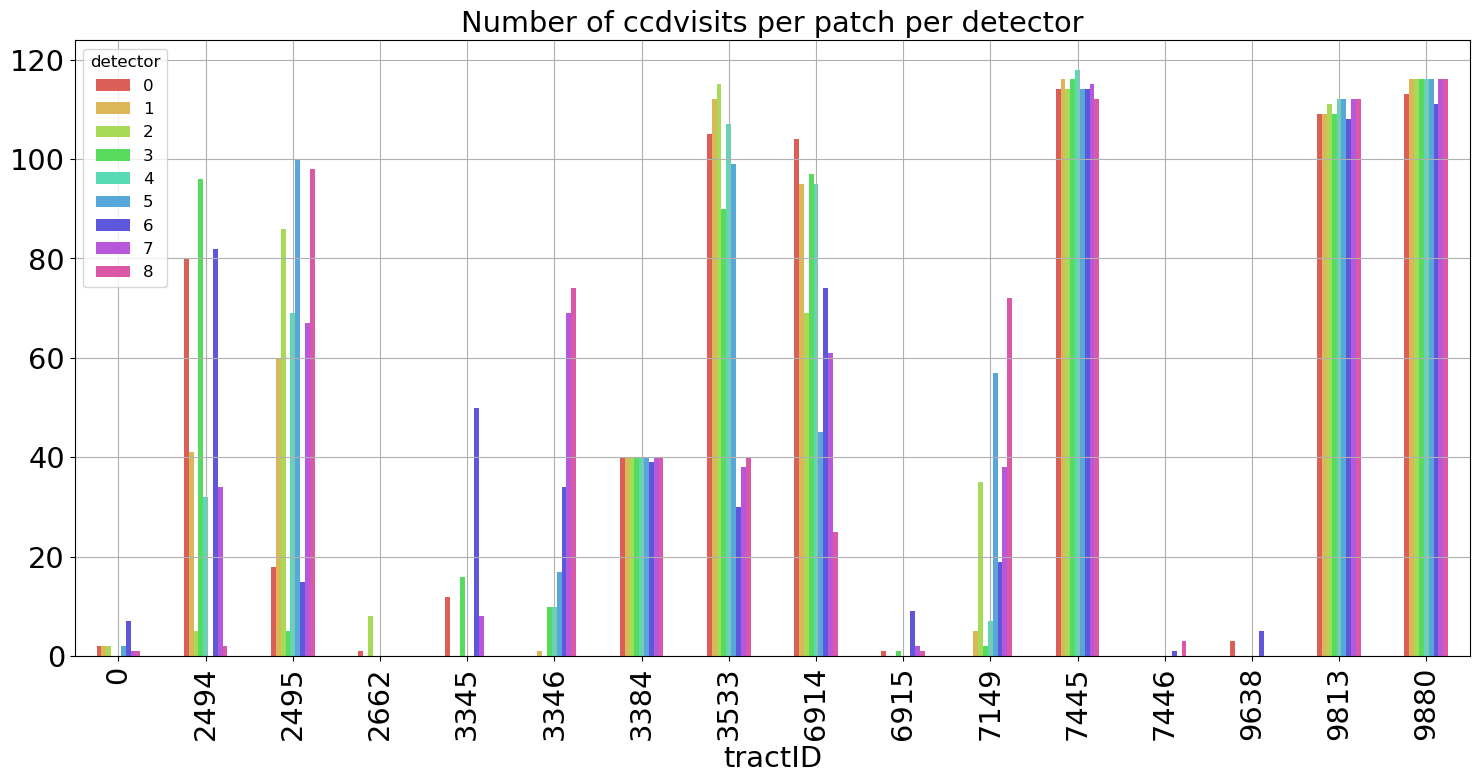

In [25]:
df_ccdvisit_pertractdet.plot.bar(color=all_det_colors,title="Number of ccdvisits per patch per detector",grid=True) 

In [27]:
ccd_visit_table_sel = ccd_visit_table[ccd_visit_table.tractID == tract_sel]

In [28]:
ccd_visit_table_sel

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865999104,7024040300541,r_03,r,279.355968,-48.037617,40.614174,31.247932,1.489538,797.449951,26.228256,0.005197,0.003065,1800,-0.000286,-0.000233,0.010674,0.009995,-0.000273,0.009937,0.006678,0.008451,190.339890,25.269243,1.153816,0.736598,0.991069,-48.037617,0,0.702109,144.918102,2024-04-04 07:16:47.980994,60404.303333,30.0,2024-04-04 07:16:32.980994,60404.303160,33.0560,4071,3999,279.122221,-48.010669,279.399948,-47.881733,279.589986,-48.064091,279.311725,-48.193479,138240,540,20240403,2494,191
730865999105,7024040300541,r_03,r,279.643677,-47.903237,40.786217,31.227333,1.486016,785.748047,24.065950,0.005252,0.003049,1733,0.000307,-0.000159,0.010712,0.010907,-0.000241,0.009790,0.006585,0.006671,221.791214,24.807823,1.159293,0.747568,0.954165,-47.903237,1,0.700599,144.918102,2024-04-04 07:16:47.980994,60404.303333,30.0,2024-04-04 07:16:32.980994,60404.303160,33.0560,4071,3999,279.410359,-47.876875,279.686680,-47.747248,279.877246,-47.929128,279.600416,-48.059216,138241,540,20240403,2494,223
730865999106,7024040300541,r_03,r,279.929900,-47.768146,40.958786,31.248362,1.487677,804.563599,24.881762,0.004893,0.002858,1791,0.000378,0.000256,0.010892,0.011347,0.000124,0.009305,0.006254,0.004737,197.574738,25.128401,1.156705,0.730085,0.991853,-47.768146,2,0.701413,144.918102,2024-04-04 07:16:47.980994,60404.303333,30.0,2024-04-04 07:16:32.980994,60404.303160,33.0560,4071,3999,279.697036,-47.742366,279.971924,-47.612070,280.162993,-47.793461,279.887621,-47.924227,138242,540,20240403,2494,238
730865999107,7024040300541,r_03,r,279.557184,-48.230301,40.774620,31.255405,1.484635,804.398560,25.673428,0.005221,0.003047,1862,-0.000256,-0.000010,0.009989,0.010664,-0.000302,0.009940,0.006697,0.010144,185.445221,25.566191,1.161451,0.730235,1.004804,-48.230301,3,0.699819,144.918102,2024-04-04 07:16:47.980994,60404.303333,30.0,2024-04-04 07:16:32.980994,60404.303160,33.0560,4071,3999,279.322425,-48.203754,279.600717,-48.074339,279.792196,-48.256370,279.513391,-48.386244,138243,540,20240403,2494,155
730865999108,7024040300541,r_03,r,279.845455,-48.095421,40.946117,31.252205,1.490668,806.067078,24.616596,0.005892,0.003045,1711,-0.000168,0.000569,0.011599,0.012136,0.000397,0.010876,0.007305,0.018211,248.889099,25.158411,1.152068,0.728723,0.998898,-48.095421,4,0.702503,144.918102,2024-04-04 07:16:47.980994,60404.303333,30.0,2024-04-04 07:16:32.980994,60404.303160,33.0560,4071,3999,279.611149,-48.069464,279.888006,-47.939350,280.079998,-48.120900,279.802645,-48.251477,138244,540,20240403,2494,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866044417,7024040300718,i_06,i,279.711876,-47.791810,20.039753,31.102289,1.494666,1162.742798,28.736580,0.003487,0.002164,1762,0.000003,0.000364,0.012002,0.011309,-0.000062,0.010940,0.007320,0.004771,242.233978,31.260721,1.103345,0.928064,1.017627,-47.791810,1,0.704589,165.951197,2024-04-04 09:40:12.148499,60404.402918,30.0,2024-04-04 09:39:57.148499,60404.402745,33.0566,4071,3999,279.508415,-47.711535,279.834397,-47.656300,279.915977,-47.871732,279.588710,-47.927198,183553,717,20240403,2494,239
730866044419,7024040300718,i_06,i,279.457070,-48.076643,20.186350,31.109850,1.494664,1167.556641,30.137480,0.003384

In [ ]:
#llcra                                            279.122221
#llcdec                                           -48.010669
#ulcra                                            279.399948
#ulcdec                                           -47.881733
#urcra                                            279.589986
#urcdec                                           -48.064091
#lrcra                                            279.311725
#lrcdec                                           -48.193479

In [30]:
one_visit = ccd_visit_table_sel.iloc[0]

In [34]:
all_corners_ra = [one_visit["llcra"],
                  one_visit["ulcra"],
                  one_visit["urcra"],
                  one_visit["lrcra"],
                  one_visit["llcra"]]

In [35]:
all_corners_dec = [one_visit["llcdec"],
                  one_visit["ulcdec"],
                  one_visit["urcdec"],
                  one_visit["lrcdec"],
                  one_visit["llcdec"]]

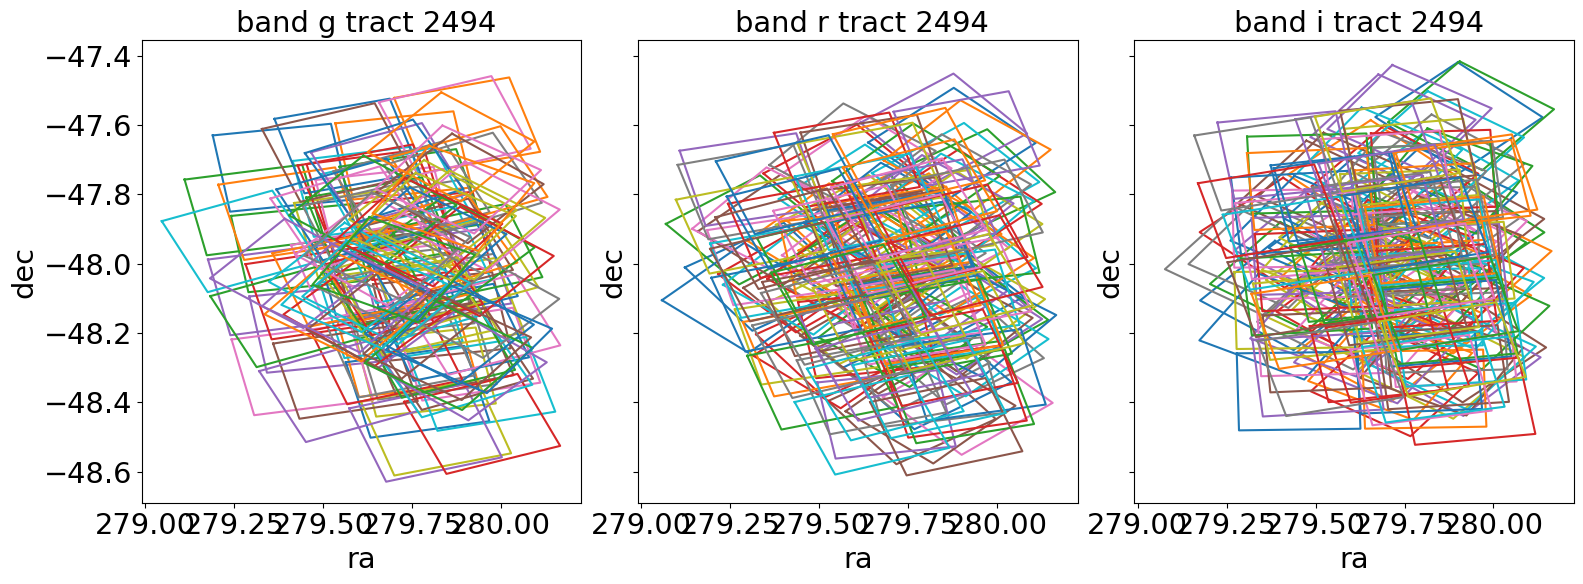

In [44]:
fig,axs = plt.subplots(1,3,figsize=(16,6),sharex=True,sharey=True)
                   
for index, one_visit in ccd_visit_table_sel.iterrows():
    band = one_visit["band"]
    if band == "g":
        ax = axs[0]
    elif band == "r":
        ax = axs[1]
    elif band == "i":
        ax = axs[2]
    else:
        pass
        
    
    all_corners_ra = [one_visit["llcra"],
                  one_visit["ulcra"],
                  one_visit["urcra"],
                  one_visit["lrcra"],
                  one_visit["llcra"]]
    all_corners_dec = [one_visit["llcdec"],
                  one_visit["ulcdec"],
                  one_visit["urcdec"],
                  one_visit["lrcdec"],
                  one_visit["llcdec"]]
    ax.set_title(f" band {band} tract {tract_sel}")
    ax.set_xlabel("ra")
    ax.set_ylabel("dec")
    ax.plot(all_corners_ra,all_corners_dec )

plt.tight_layout()